In [3]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/FiducialVolumeStudy


In [4]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [5]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [7]:
categories_list = ['1000kg','1500kg','2000kg','2500kg']
outputdir = '/p/lustre2/lenardo1/sensitivity_output/Apr10_SensitivityVsFiducialVolume_D024/'


all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if filename.endswith('.h5') and 'reanalyzed' in filename]

dfdict = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
    dfdict[category] = pd.concat(df_list,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict[category])))

Loading data for 1000kg
---> Loaded 5000 toy datasets
Loading data for 1500kg
---> Loaded 5000 toy datasets
Loading data for 2000kg
---> Loaded 5000 toy datasets
Loading data for 2500kg
---> Loaded 5000 toy datasets


In [17]:
dfdict['1000kg'].columns

Index(['90CL_crossing', 'best_fit_converged', 'best_fit_covar',
       'best_fit_errors', 'best_fit_iterations', 'best_fit_nll',
       'best_fit_parameters', 'fixed_fit_acc_covar', 'fixed_fit_converged',
       'fixed_fit_errors', 'fixed_fit_parameters', 'input_parameters',
       'lambda', 'num_iterations', 'num_signal', '90CL_crossing_EXACT'],
      dtype='object')

In [21]:
# Get the median values of lambda

maskdict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or np.sum(row['fixed_fit_converged']) < len(row['fixed_fit_converged'])-2 \
            or not row['best_fit_covar'] \
            or not row['best_fit_converged'] \
            or row['90CL_crossing'] < 0.01\
            or np.min(row['lambda']) < -0.1\
            or row['best_fit_nll']>5.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict[key])/len(maskdict[key])))
            
    

Running 1000kg
---> Convergence fraction: 1.0
Running 1500kg
---> Convergence fraction: 1.0
Running 2000kg
---> Convergence fraction: 1.0
Running 2500kg
---> Convergence fraction: 0.999


Running 1000kg
---> Median 90%CL on signal counts: 2.7402740274027404
Running 1500kg
---> Median 90%CL on signal counts: 3.4603460346034605
Running 2000kg
---> Median 90%CL on signal counts: 4.2004200420042
Running 2500kg
---> Median 90%CL on signal counts: 5.140514051405141


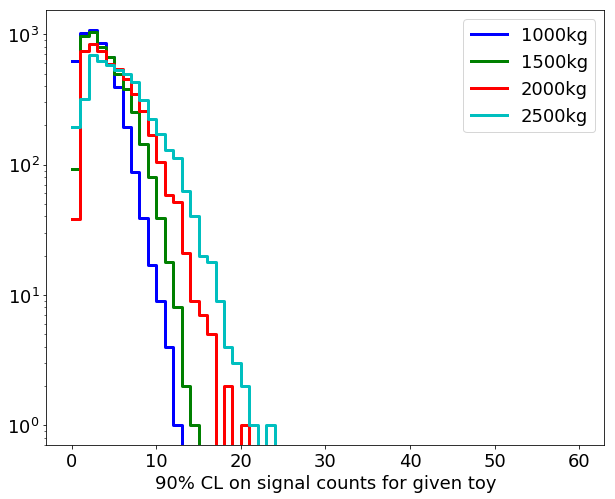

In [22]:
histdict = dict()
mediandict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    histdict[key] = hl.hist(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]], bins=np.linspace(0.,60.,61))
    
    mediandict[key] = np.median(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]])  

#     histdict[key] = hl.hist(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]], bins=np.linspace(0.,60.,61))
    
#     mediandict[key] = np.median(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]])
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict[key]))
    
    hl.plot1d(histdict[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')

In [29]:
def ComputeHalflifeFromNumCounts( counts, fiducial_mass_kg ):
    
    # Returns the half life which would give (on average) the input number of signal counts
    
    N_A = 6.02e23 # atoms/mol
    FidMass = fiducial_mass_kg # kg
    AtomicMass = 135.8 # g/mol
    EnrichmentFraction = 0.9
    SigEfficiency = 0.96
    Livetime = 10 # years
    
    return FidMass*1.e3 / AtomicMass * N_A * EnrichmentFraction * Livetime * \
            SigEfficiency * np.log(2) / counts

In [30]:
xvals = []
yvals = []

for key,median in mediandict.items():
    mass = float(key[:-2])
    xvals.append(mass)
    yvals.append(ComputeHalflifeFromNumCounts(median,mass))
    
xvals.append(3281)
yvals.append(1.32e28)

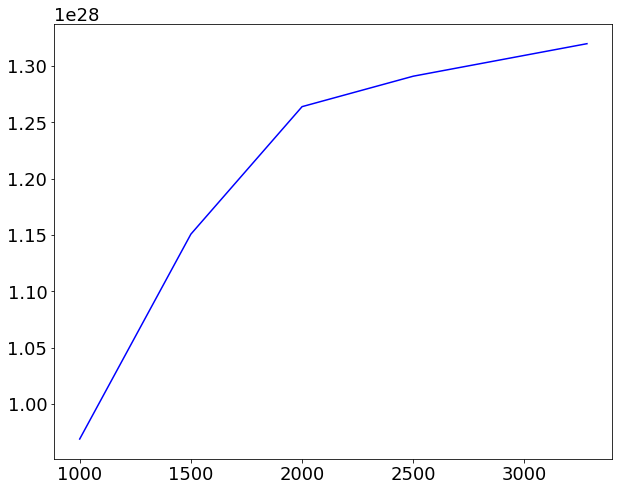

In [31]:
plt.plot(xvals,yvals,'-b')

In [34]:
output_array = np.vstack((np.array(xvals),np.array(yvals)))

np.savetxt('../PaperPlots/SensitivityVsFiducialVolume.txt',np.transpose(output_array))